In [3]:
# imports
import tensorflow as tf

from tensorflow.keras.layers import Input, LSTM, GRU, SimpleRNN, Dense, GlobalMaxPool1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import yfinance as yf


2024-06-08 21:31:50.734015: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-08 21:31:50.734083: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-08 21:31:50.735338: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-08 21:31:50.742891: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-08 21:31:51.516801: W tensorflow/compiler/tf2

# Get the stock price from Yahoo Finance

In [15]:
def get_stock_price(ticker, period="5y", interval="1d"):
    stock = yf.Ticker(ticker)
    stock_info = stock.history(period=period, interval=interval)
    return stock_info

if __name__ == "__main__":
    ticker_symbol = "GC=F"
    stock_data = get_stock_price(ticker_symbol)
    print(stock_data)

                                  Open         High          Low        Close  \
Date                                                                            
2019-06-10 00:00:00-04:00  1335.800049  1336.500000  1324.099976  1324.699951   
2019-06-11 00:00:00-04:00  1328.400024  1328.400024  1319.099976  1326.400024   
2019-06-12 00:00:00-04:00  1326.900024  1334.500000  1326.900024  1331.900024   
2019-06-13 00:00:00-04:00  1331.599976  1341.099976  1331.599976  1339.199951   
2019-06-14 00:00:00-04:00  1345.400024  1355.400024  1339.300049  1340.099976   
...                                ...          ...          ...          ...   
2024-06-03 00:00:00-04:00  2322.600098  2347.500000  2312.000000  2346.600098   
2024-06-04 00:00:00-04:00  2347.500000  2347.699951  2313.899902  2325.500000   
2024-06-05 00:00:00-04:00  2326.399902  2354.300049  2326.199951  2354.100098   
2024-06-06 00:00:00-04:00  2355.000000  2375.800049  2355.000000  2370.300049   
2024-06-07 00:00:00-04:00  2

In [16]:
# Turn into a dataframe
df = pd.DataFrame(stock_data)
df.head(5)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2019-06-10 00:00:00-04:00,1335.800049,1336.500000,1324.099976,1324.699951,268,0.0,0.0
2019-06-11 00:00:00-04:00,1328.400024,1328.400024,1319.099976,1326.400024,201,0.0,0.0
2019-06-12 00:00:00-04:00,1326.900024,1334.500000,1326.900024,1331.900024,139,0.0,0.0
2019-06-13 00:00:00-04:00,1331.599976,1341.099976,1331.599976,1339.199951,157,0.0,0.0
2019-06-14 00:00:00-04:00,1345.400024,1355.400024,1339.300049,1340.099976,914,0.0,0.0


In [25]:
# Date is an index, lets fix that
df['Date'] = df.index
df.reset_index(drop=True,inplace=True)

In [28]:
# Fix the date to only include dates not times
df['Date'] = df['Date'].dt.date

In [29]:
df['Name'] = 'GC=F'

In [30]:
df.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Date,Name
0,1335.800049,1336.500000,1324.099976,1324.699951,268,0.0,0.0,2019-06-10,GC=F
1,1328.400024,1328.400024,1319.099976,1326.400024,201,0.0,0.0,2019-06-11,GC=F
2,1326.900024,1334.500000,1326.900024,1331.900024,139,0.0,0.0,2019-06-12,GC=F
3,1331.599976,1341.099976,1331.599976,1339.199951,157,0.0,0.0,2019-06-13,GC=F
4,1345.400024,1355.400024,1339.300049,1340.099976,914,0.0,0.0,2019-06-14,GC=F


In [31]:
# Start by trying to predict the price itself
series = df['Close'].values.reshape(-1, 1)

In [32]:
# Normalize the data
scaler = StandardScaler()
scaler.fit(series[:len(series) // 2])
series = scaler.transform(series).flatten()

In [33]:
### build the dataset
# let's see if we can use T past values to predict the next value
T = 10
D = 1
X = []
Y = []
for t in range(len(series) - T):
  x = series[t:t+T]
  X.append(x)
  y = series[t+T]
  Y.append(y)

X = np.array(X).reshape(-1, T, 1) # Now the data should be N x T x D
Y = np.array(Y)
N = len(X)
print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (1250, 10, 1) Y.shape (1250,)


In [35]:
# try autoregressive RNN model
i = Input(shape=(T, 1))
x = LSTM(5)(i)
x = Dense(1)(x)
model = Model(i, x)
model.compile(
  loss='mse',
  optimizer=Adam(learning_rate=0.1),
)

# train the RNN
r = model.fit(
  X[:-N//2], Y[:-N//2],
  epochs=80,
  validation_data=(X[-N//2:], Y[-N//2:]),
)

2024-06-08 21:45:12.690463: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-08 21:45:13.024296: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-08 21:45:13.024360: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-08 21:45:13.029004: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-08 21:45:13.029078: I external/local_xla/xla/stream_executor

Epoch 1/80


2024-06-08 21:45:15.506436: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
2024-06-08 21:45:15.972716: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f23e735abd0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-06-08 21:45:15.972774: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1650 Ti, Compute Capability 7.5
2024-06-08 21:45:16.003392: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1717872316.148096 2704314 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


20/20 [==============================] - 3s 36ms/step - loss: 0.1735 - val_loss: 0.4066
Epoch 2/80
20/20 [==============================] - 0s 15ms/step - loss: 0.0179 - val_loss: 0.2676
Epoch 3/80
20/20 [==============================] - 0s 17ms/step - loss: 0.0164 - val_loss: 0.3050
Epoch 4/80
20/20 [==============================] - 0s 16ms/step - loss: 0.0160 - val_loss: 0.3958
Epoch 5/80
20/20 [==============================] - 0s 14ms/step - loss: 0.0148 - val_loss: 0.2617
Epoch 6/80
20/20 [==============================] - 0s 15ms/step - loss: 0.0171 - val_loss: 0.2762
Epoch 7/80
20/20 [==============================] - 0s 13ms/step - loss: 0.0154 - val_loss: 0.3048
Epoch 8/80
20/20 [==============================] - 0s 16ms/step - loss: 0.0155 - val_loss: 0.2055
Epoch 9/80
20/20 [==============================] - 0s 15ms/step - loss: 0.0160 - val_loss: 0.2808
Epoch 10/80
20/20 [==============================] - 0s 15ms/step - loss: 0.0152 - val_loss: 0.1910
Epoch 11/80
20/20 [=

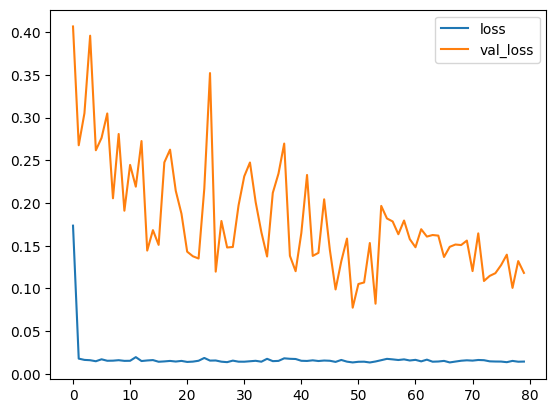

In [36]:
# Plot loss per iteration
import matplotlib.pyplot as plt
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()

40/40 [==============================] - 1s 5ms/step
(1250, 1)


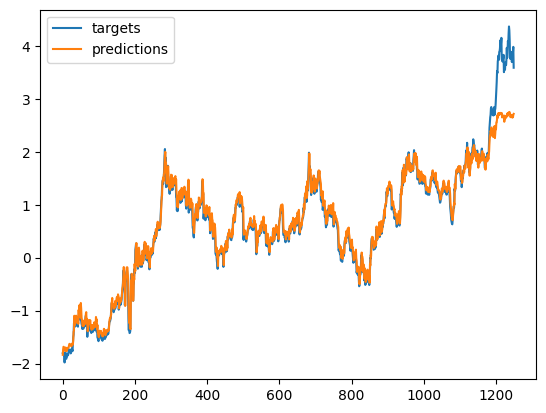

In [37]:
# One-step forecast using true targets
outputs = model.predict(X)
print(outputs.shape)
predictions = outputs[:,0]

plt.plot(Y, label='targets')
plt.plot(predictions, label='predictions')
plt.legend()
plt.show()

Seems like a very good fit but it is not realistic

## Try a more realistic approach

In [39]:
# calculate returns by first shifting the data
df['PrevClose'] = df['Close'].shift(1) # move everything up 1


In [41]:
# then the return is
# (x[t] - x[t-1]) / x[t-1]
df['Return'] = (df['Close'] - df['PrevClose']) / df['PrevClose']

In [42]:
df.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Date,Name,PrevClose,Return
0,1335.800049,1336.500000,1324.099976,1324.699951,268,0.0,0.0,2019-06-10,GC=F,NaN,NaN
1,1328.400024,1328.400024,1319.099976,1326.400024,201,0.0,0.0,2019-06-11,GC=F,1324.699951,0.001283
2,1326.900024,1334.500000,1326.900024,1331.900024,139,0.0,0.0,2019-06-12,GC=F,1326.400024,0.004147
3,1331.599976,1341.099976,1331.599976,1339.199951,157,0.0,0.0,2019-06-13,GC=F,1331.900024,0.005481
4,1345.400024,1355.400024,1339.300049,1340.099976,914,0.0,0.0,2019-06-14,GC=F,1339.199951,0.000672


<Axes: >

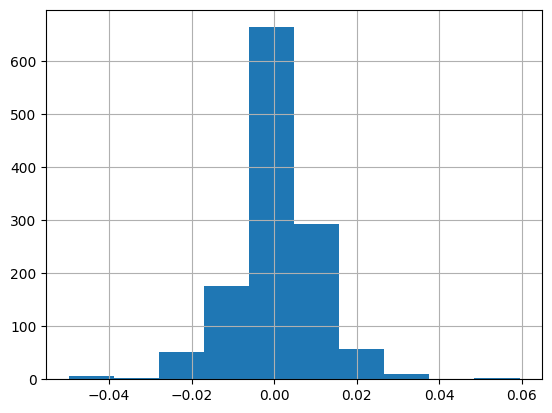

In [43]:
# Now let's try an LSTM to predict returns
df['Return'].hist()

In [44]:
series = df['Return'].values[1:].reshape(-1, 1)

# Normalize the data
scaler = StandardScaler()
scaler.fit(series[:len(series) // 2])
series = scaler.transform(series).flatten()

In [45]:
### build the dataset
# let's see if we can use T past values to predict the next value
T = 10
D = 1
X = []
Y = []
for t in range(len(series) - T):
  x = series[t:t+T]
  X.append(x)
  y = series[t+T]
  Y.append(y)

X = np.array(X).reshape(-1, T, 1) # Now the data should be N x T x D
Y = np.array(Y)
N = len(X)
print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (1249, 10, 1) Y.shape (1249,)


In [46]:
# try autoregressive RNN model
i = Input(shape=(T, 1))
x = LSTM(5)(i)
x = Dense(1)(x)
model = Model(i, x)
model.compile(
  loss='mse',
  optimizer=Adam(learning_rate=0.01),
)

# train the RNN
r = model.fit(
  X[:-N//2], Y[:-N//2],
  epochs=80,
  validation_data=(X[-N//2:], Y[-N//2:]),
)

Epoch 1/80
20/20 [==============================] - 2s 43ms/step - loss: 0.9939 - val_loss: 0.6764
Epoch 2/80
20/20 [==============================] - 0s 18ms/step - loss: 0.9879 - val_loss: 0.6794
Epoch 3/80
20/20 [==============================] - 0s 19ms/step - loss: 0.9841 - val_loss: 0.6804
Epoch 4/80
20/20 [==============================] - 0s 21ms/step - loss: 0.9815 - val_loss: 0.6770
Epoch 5/80
20/20 [==============================] - 0s 16ms/step - loss: 0.9787 - val_loss: 0.6825
Epoch 6/80
20/20 [==============================] - 0s 14ms/step - loss: 0.9781 - val_loss: 0.6854
Epoch 7/80
20/20 [==============================] - 0s 14ms/step - loss: 0.9756 - val_loss: 0.6867
Epoch 8/80
20/20 [==============================] - 0s 19ms/step - loss: 0.9700 - val_loss: 0.6893
Epoch 9/80
20/20 [==============================] - 0s 15ms/step - loss: 0.9675 - val_loss: 0.6983
Epoch 10/80
20/20 [==============================] - 0s 14ms/step - loss: 0.9656 - val_loss: 0.6928
Epoch 11/

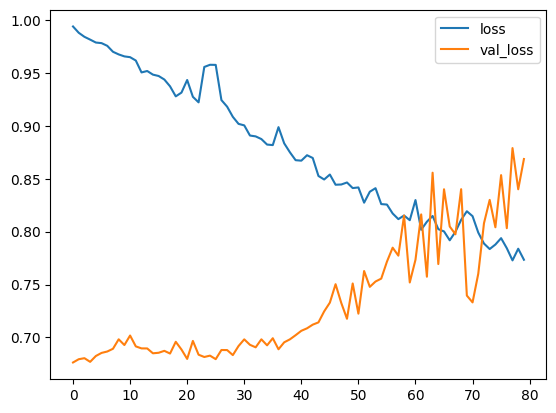

In [47]:
# Plot loss per iteration
import matplotlib.pyplot as plt
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()

40/40 [==============================] - 0s 4ms/step
(1249, 1)


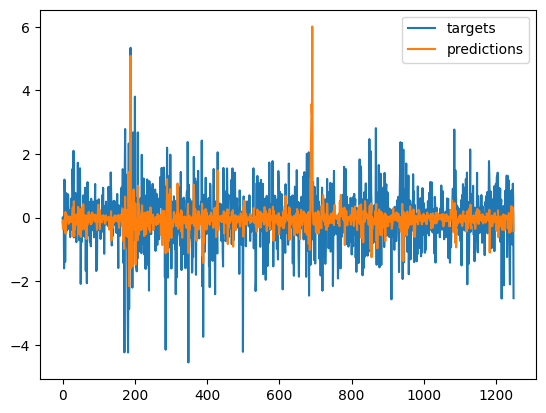

In [48]:
# One-step forecast using true targets
outputs = model.predict(X)
print(outputs.shape)
predictions = outputs[:,0]

plt.plot(Y, label='targets')
plt.plot(predictions, label='predictions')
plt.legend()
plt.show()

1/1 [==============================] - 0s 25ms/step


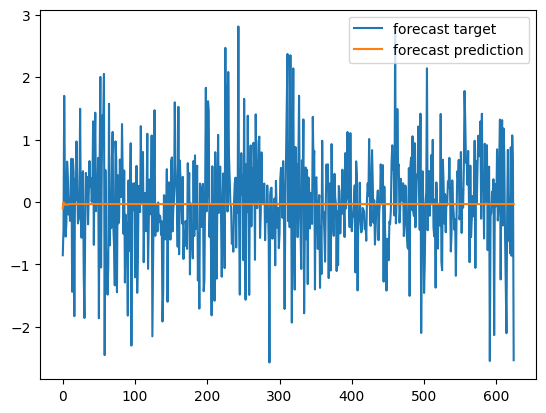

In [49]:
# Multi-step forecast
validation_target = Y[-N//2:]
validation_predictions = []

# first validation input
last_x = X[-N//2] # 1-D array of length T

while len(validation_predictions) < len(validation_target):
  p = model.predict(last_x.reshape(1, T, 1))[0,0] # 1x1 array -> scalar
  
  # update the predictions list
  validation_predictions.append(p)
  
  # make the new input
  last_x = np.roll(last_x, -1)
  last_x[-1] = p

plt.plot(validation_target, label='forecast target')
plt.plot(validation_predictions, label='forecast prediction')
plt.legend()

In [50]:
# Now turn the full data into numpy arrays

# Not yet in the final "X" format!
input_data = df[['Open', 'High', 'Low', 'Close', 'Volume']].values
targets = df['Return'].values

In [51]:
# Now make the actual data which will go into the neural network
T = 10 # the number of time steps to look at to make a prediction for the next day
D = input_data.shape[1]
N = len(input_data) - T 

In [52]:
# normalize the inputs
Ntrain = len(input_data) * 2 // 3
scaler = StandardScaler()
scaler.fit(input_data[:Ntrain + T - 1])
input_data = scaler.transform(input_data)

In [53]:
# Setup X_train and Y_train
X_train = np.zeros((Ntrain, T, D))
Y_train = np.zeros(Ntrain)

for t in range(Ntrain):
  X_train[t, :, :] = input_data[t:t+T]
  Y_train[t] = (targets[t+T] > 0)

In [54]:
# Setup X_test and Y_test
X_test = np.zeros((N - Ntrain, T, D))
Y_test = np.zeros(N - Ntrain)

for u in range(N - Ntrain):
  # u counts from 0...(N - Ntrain)
  # t counts from Ntrain...N
  t = u + Ntrain
  X_test[u, :, :] = input_data[t:t+T]
  Y_test[u] = (targets[t+T] > 0)

In [55]:
# make the RNN
i = Input(shape=(T, D))
x = LSTM(50)(i)
x = Dense(1, activation='sigmoid')(x)
model = Model(i, x)
model.compile(
  loss='binary_crossentropy',
  optimizer=Adam(learning_rate=0.001),
  metrics=['accuracy'],
)

In [56]:
# train the RNN
r = model.fit(
  X_train, Y_train,
  batch_size=32,
  epochs=300,
  validation_data=(X_test, Y_test),
)

Epoch 1/300
27/27 [==============================] - 3s 31ms/step - loss: 0.6951 - accuracy: 0.5274 - val_loss: 0.6931 - val_accuracy: 0.5244
Epoch 2/300
27/27 [==============================] - 0s 15ms/step - loss: 0.6911 - accuracy: 0.5298 - val_loss: 0.6997 - val_accuracy: 0.5317
Epoch 3/300
27/27 [==============================] - 0s 16ms/step - loss: 0.6879 - accuracy: 0.5464 - val_loss: 0.6994 - val_accuracy: 0.5317
Epoch 4/300
27/27 [==============================] - 0s 15ms/step - loss: 0.6859 - accuracy: 0.5452 - val_loss: 0.7021 - val_accuracy: 0.5146
Epoch 5/300
27/27 [==============================] - 0s 16ms/step - loss: 0.6885 - accuracy: 0.5417 - val_loss: 0.7032 - val_accuracy: 0.4829
Epoch 6/300
27/27 [==============================] - 0s 18ms/step - loss: 0.6863 - accuracy: 0.5357 - val_loss: 0.7041 - val_accuracy: 0.5073
Epoch 7/300
27/27 [==============================] - 0s 17ms/step - loss: 0.6852 - accuracy: 0.5440 - val_loss: 0.7072 - val_accuracy: 0.5146
Epoch 

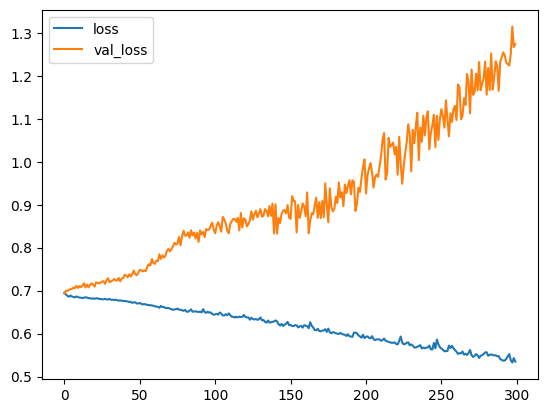

In [57]:
# plot the loss
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

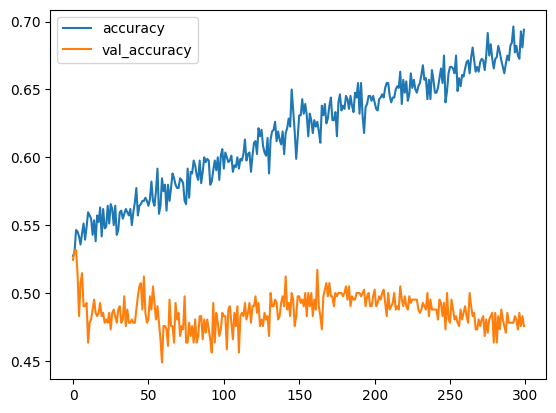

In [58]:
# Plot accuracy per iteration
plt.plot(r.history['accuracy'], label='accuracy')
plt.plot(r.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()